# Big_Event_Classifier

# Import packages and Datasets

In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import keras
from keras import models
from keras import layers
from keras.layers import LSTM

import gc #Garbage Collector interface
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score #The F-Measure is a popular metric for imbalanced classification.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from sklearn.utils import class_weight

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
# import Google Drive 套件
from google.colab import drive

# 將自己的雲端硬碟掛載上去
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# 透過 gdrive/My Drive/... 來存取檔案
data_df = pd.read_excel('gdrive/My Drive/金融科技Final_project/2019+2020年新聞資訊事件(5.28).xlsx')

In [4]:
data_df.head()

,個股代號,公司簡稱,事件日,TCRI(年/月),事件強度,大事件類別,小事件類別,事件內容,Unnamed: 8,content_tokenized
0,1218,泰山,20190101,6(2018/09),0,M_經營層,MT06_高管異動,發言人林俐婉內部調動，由江巍峰接任。。,19.0,發言人 林俐婉 內部 調動 由 江巍峰 接任
1,1503,士電,20190101,4(2018/09),0,M_經營層,MT06_高管異動,內部稽核主管林志強內部調動，由莊文清接任。。,22.0,內部 稽核 主管 林志強 內部 調動 由 莊文清 接任
2,1504,東元,20190101,4(2018/09),0,M_經營層,MT06_高管異動,會計主管藍俊雄內部調動，由林鴻名接任。。,20.0,會計 主管 藍俊雄 內部 調動 由 林鴻名 接任
3,1709,和益,20190101,5(2018/09),0,M_經營層,MT06_高管異動,內部稽核主管游本詮內部調動，由曾筱茜接任。。,22.0,內部 稽核 主管 游本詮 內部 調動 由 曾筱茜 接任
4,1721,三晃,20190101,7(2018/09),0,M_經營層,MT06_高管異動,財務經理洪廷宜內部調動，由王婷渝接任。。,20.0,財務 經理 洪廷宜 內部 調動 由 王婷渝 接任


## Define "preprocess_text" functions

In [0]:
def preprocess_text(corpus, MAX_NUM_WORDS = 10000, MAX_SEQUENCE_LENGTH = 1000):
  tokenizer = keras .preprocessing.text.Tokenizer(num_words=MAX_NUM_WORDS)
  tokenizer.fit_on_texts(corpus)
  output = tokenizer.texts_to_sequences(corpus)
  output = keras .preprocessing .sequence .pad_sequences(output, maxlen=MAX_SEQUENCE_LENGTH)
  return output

## Data preprocessing

In [0]:
x = preprocess_text(corpus = data_df.content_tokenized, MAX_NUM_WORDS = 10000, MAX_SEQUENCE_LENGTH = 1305)

y = data_df["大事件類別"]

In [7]:
x.shape

(36717, 1305)

## Split data into training dataset and testing dataset

In [8]:
# Split data to training data and testing data 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_par_train, X_val, y_par_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Calculate class weights

print(np.unique(y_train))

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

print(class_weights)

# One-hot encoding
enc = OneHotEncoder(sparse=False)
y_train = enc.fit(np.asarray(y).reshape(-1, 1))
y_par_train = enc.transform(np.asarray(y_par_train).reshape(-1, 1))
y_val = enc.transform(np.asarray(y_val).reshape(-1, 1))
y_test = enc.transform(np.asarray(y_test).reshape(-1, 1))

# Oversampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_par_train_res, y_par_train_res = ros.fit_resample(X_par_train, y_par_train)

['A_會計/財報分析' 'F_市場交易' 'I_產業前景' 'M_經營層' 'R_危機']
[11.34092664  1.09826136  0.34324277  0.98666443 13.44302059]


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [9]:
# save this encoder

from joblib import dump, load
dump(enc, 'gdrive/My Drive/金融科技Final_project/BE_enc.joblib') 

['gdrive/My Drive/金融科技Final_project/BE_enc.joblib']

# Model 1: 

Reduce the units of LSTM to 32

Use Random Oversampling

sequence length = 1305 (max length of our text data)

In [0]:
model_1 = models.Sequential()
model_1.add(layers.Embedding(10000, 128)) #256
# model_1.add(layers.LSTM(128,dropout=0.2,recurrent_dropout=0.2,return_sequences=True))
model_1.add(layers.LSTM(32,dropout=0,recurrent_dropout=0)) #128
model_1.add(layers.Dense(5, activation='softmax'))

model_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Iterate on your training data by calling the fit() method of your model
history = model_1.fit(X_par_train_res, y_par_train_res,
                    epochs=20,
                    batch_size=500,
                    validation_data = (X_val,y_val)
                    #class_weight = class_weights
                    )

# plot the results of loss values from the training set and validtion set
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# plot the results of accuracy from the training set and validtion set
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Performance on partial training set

In [0]:
preds_Y_par_train = model_1.predict(X_par_train)
preds_Y_par_train =(preds_Y_par_train>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_par_train_copy = enc.inverse_transform(preds_Y_par_train)
y_par_train_copy = enc.inverse_transform(y_par_train)

# Change all categorical data to numbers, so we can compute accuracy, precision, confusion matrix,....
le = sklearn.preprocessing.LabelEncoder()
y_par_train_copy = le.fit_transform(y_par_train_copy)
preds_Y_par_train_copy = le.transform(preds_Y_par_train_copy)

accuracy = accuracy_score(y_par_train_copy, preds_Y_par_train_copy)
precision = precision_score(y_par_train_copy, preds_Y_par_train_copy,average=None) # average=None: The precision scores for each class are returned
recall = recall_score(y_par_train_copy, preds_Y_par_train_copy,average=None)
f1 = f1_score(y_par_train_copy, preds_Y_par_train_copy,average=None)
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')

c_matrix = confusion_matrix(y_par_train_copy, preds_Y_par＿train_copy,labels=[0,1,2,3,4])
print('Confusion matrix: ')
print(c_matrix)

In [0]:
le.classes_

## Performance on testing set

In [0]:
preds_Y_test = model_1.predict(X_test)
preds_Y_test =(preds_Y_test>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_test_copy = enc.inverse_transform(preds_Y_test)
y_test_copy = enc.inverse_transform(y_test)

# Change all categorical data to numbers, so we can compute accuracy, precision, confusion matrix,....
le = sklearn.preprocessing.LabelEncoder()
y_test_copy = le.fit_transform(y_test_copy)
preds_Y_test_copy = le.transform(preds_Y_test_copy)

accuracy = accuracy_score(y_test_copy, preds_Y_test_copy)
precision = precision_score(y_test_copy, preds_Y_test_copy,average=None) # average=None: The precision scores for each class are returned
recall = recall_score(y_test_copy, preds_Y_test_copy,average=None)
f1 = f1_score(y_test_copy, preds_Y_test_copy,average=None)
c_matrix = confusion_matrix(y_test_copy, preds_Y_test_copy,labels=[0,1,2,3,4])
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')
print('Confusion matrix: ')
print(c_matrix)

In [0]:
le.classes_

# Model 2: 

Reduce the units of LSTM to 16

Use Random Oversampling

sequence length = 1305 (max length of our text data)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 68410 samples, validate on 5875 samples
Epoch 1/20
68410/68410 [==============================] - 303s 4ms/step - loss: 0.6850 - accuracy: 0.9046 - val_loss: 0.1792 - val_accuracy: 0.9636
Epoch 2/20
68410/68410 [==============================] - 304s 4ms/step - loss: 0.0855 - accuracy: 0.9846 - val_loss: 0.1206 - val_accuracy: 0.9670
Epoch 3/20
68410/68410 [==============================] - 302s 4ms/step - loss: 0.0374 - accuracy: 0.9942 - val_loss: 0.1032 - val_accuracy: 0.9755
Epoch 4/20
68410/68410 [==============================] - 302s 4ms/step - loss: 0.0209 - accuracy: 0.9968 - val_loss: 0.1035 - val_accuracy: 0.9760
Epoch 5/20
68410/68410 [==============================] - 298s 4ms/step - loss: 0.0139 - accuracy: 0.9981 - val_loss: 0.1061 - val_accuracy: 0.9757
Epoch 6/20
68410/68410 [==============================] - 297s 4ms/step - loss: 0.0097 - accuracy: 0.9987 - val_loss: 0.1099 - val_accuracy: 0.9750
Epoch 7/20
68410/68410 [==============================] - 302s 

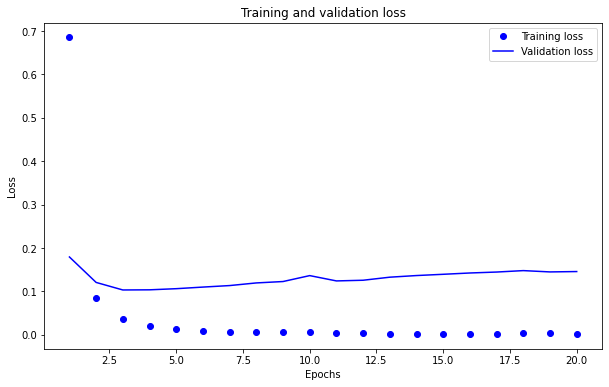

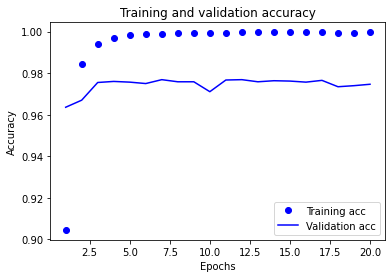

In [0]:
model_2 = models.Sequential()
model_2.add(layers.Embedding(10000, 128))
# model_1.add(layers.LSTM(128,dropout=0.2,recurrent_dropout=0.2,return_sequences=True))
model_2.add(layers.LSTM(16,dropout=0,recurrent_dropout=0))
model_2.add(layers.Dense(5, activation='softmax'))

model_2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Iterate on your training data by calling the fit() method of your model
history = model_2.fit(X_par_train_res, y_par_train_res,
                    epochs=20,
                    batch_size=500,
                    validation_data = (X_val,y_val)
                    #class_weight = class_weights
                    )

# plot the results of loss values from the training set and validtion set
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# plot the results of accuracy from the training set and validtion set
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Performance on partial training set

In [0]:
preds_Y_par_train = model_2.predict(X_par_train)
preds_Y_par_train =(preds_Y_par_train>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_par_train_copy = enc.inverse_transform(preds_Y_par_train)
y_par_train_copy = enc.inverse_transform(y_par_train)

# Change all categorical data to numbers, so we can compute accuracy, precision, confusion matrix,....
le = sklearn.preprocessing.LabelEncoder()
y_par_train_copy = le.fit_transform(y_par_train_copy)
preds_Y_par_train_copy = le.transform(preds_Y_par_train_copy)

accuracy = accuracy_score(y_par_train_copy, preds_Y_par_train_copy)
precision = precision_score(y_par_train_copy, preds_Y_par_train_copy,average=None) # average=None: The precision scores for each class are returned
recall = recall_score(y_par_train_copy, preds_Y_par_train_copy,average=None)
f1 = f1_score(y_par_train_copy, preds_Y_par_train_copy,average=None)
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')

c_matrix = confusion_matrix(y_par_train_copy, preds_Y_par＿train_copy,labels=[0,1,2,3,4])
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.999319090986467

precision: [0.98831776 1.         0.99985372 0.99810726 1.        ]

recall: [1.         0.99976728 0.99912294 0.99936829 1.        ]

F1 score: [0.99412456 0.99988363 0.99948819 0.99873737 1.        ]

Confusion matrix: 
[[  423     0     0     0     0]
 [    1  4296     0     0     0]
 [    3     0 13670     9     0]
 [    1     0     2  4746     0]
 [    0     0     0     0   347]]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
le.classes_

array(['A_會計/財報分析', 'F_市場交易', 'I_產業前景', 'M_經營層', 'R_危機'], dtype=object)

## Performance on testing set

In [0]:
preds_Y_test = model_2.predict(X_test)
preds_Y_test =(preds_Y_test>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_test_copy = enc.inverse_transform(preds_Y_test)
y_test_copy = enc.inverse_transform(y_test)

# Change all categorical data to numbers, so we can compute accuracy, precision, confusion matrix,....
le = sklearn.preprocessing.LabelEncoder()
y_test_copy = le.fit_transform(y_test_copy)
preds_Y_test_copy = le.transform(preds_Y_test_copy)

accuracy = accuracy_score(y_test_copy, preds_Y_test_copy)
precision = precision_score(y_test_copy, preds_Y_test_copy,average=None) # average=None: The precision scores for each class are returned
recall = recall_score(y_test_copy, preds_Y_test_copy,average=None)
f1 = f1_score(y_test_copy, preds_Y_test_copy,average=None)
c_matrix = confusion_matrix(y_test_copy, preds_Y_test_copy,labels=[0,1,2,3,4])
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.9705882352941176

precision: [0.77142857 0.99480712 0.97244922 0.9655857  0.84536082]

recall: [0.69827586 0.97385621 0.98533239 0.95672131 0.82828283]

F1 score: [0.73303167 0.98422018 0.97884841 0.96113307 0.83673469]

Confusion matrix: 
[[  81    0   34    1    0]
 [   1 1341   16   10    9]
 [  15    2 4165   41    4]
 [   4    1   59 1459    2]
 [   4    4    9    0   82]]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
le.classes_

array(['A_會計/財報分析', 'F_市場交易', 'I_產業前景', 'M_經營層', 'R_危機'], dtype=object)

# Model 3:

Reduce the units of LSTM to 16

Use Random Oversampling

sequence length = 1305 (max length of our text data)

Drop: 0.1, recurrent dropout:0.1

In [0]:
model_3 = models.Sequential()
model_3.add(layers.Embedding(10000, 128))
# model_1.add(layers.LSTM(128,dropout=0.2,recurrent_dropout=0.2,return_sequences=True))
model_3.add(layers.LSTM(16,dropout=0.1,recurrent_dropout=0.1))
model_3.add(layers.Dense(5, activation='softmax'))

model_3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Iterate on your training data by calling the fit() method of your model
history = model_3.fit(X_par_train_res, y_par_train_res,
                    epochs=20,
                    batch_size=500,
                    validation_data = (X_val,y_val)
                    #class_weight = class_weights
                    )

# plot the results of loss values from the training set and validtion set
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# plot the results of accuracy from the training set and validtion set
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 68410 samples, validate on 5875 samples
Epoch 1/20
68410/68410 [==============================] - 359s 5ms/step - loss: 0.6877 - accuracy: 0.9062 - val_loss: 0.2482 - val_accuracy: 0.9607
Epoch 2/20
68410/68410 [==============================] - 358s 5ms/step - loss: 0.1151 - accuracy: 0.9818 - val_loss: 0.1474 - val_accuracy: 0.9695
Epoch 3/20
68410/68410 [==============================] - 365s 5ms/step - loss: 0.0549 - accuracy: 0.9907 - val_loss: 0.1222 - val_accuracy: 0.9711
Epoch 4/20
68410/68410 [==============================] - 368s 5ms/step - loss: 0.0329 - accuracy: 0.9943 - val_loss: 0.1138 - val_accuracy: 0.9721
Epoch 5/20
68410/68410 [==============================] - 368s 5ms/step - loss: 0.0234 - accuracy: 0.9959 - val_loss: 0.1285 - val_accuracy: 0.9685
Epoch 6/20
68410/68410 [==============================] - 367s 5ms/step - loss: 0.0183 - accuracy: 0.9967 - val_loss: 0.1216 - val_accuracy: 0.9736
Epoch 7/20
68410/68410 [==============================] - 367s 

KeyboardInterrupt: ignored

## Performance on partial training set

In [0]:
preds_Y_par_train = model_3.predict(X_par_train)
preds_Y_par_train =(preds_Y_par_train>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_par_train_copy = enc.inverse_transform(preds_Y_par_train)
y_par_train_copy = enc.inverse_transform(y_par_train)

# Change all categorical data to numbers, so we can compute accuracy, precision, confusion matrix,....
le = sklearn.preprocessing.LabelEncoder()
y_par_train_copy = le.fit_transform(y_par_train_copy)
preds_Y_par_train_copy = le.transform(preds_Y_par_train_copy)

accuracy = accuracy_score(y_par_train_copy, preds_Y_par_train_copy)
precision = precision_score(y_par_train_copy, preds_Y_par_train_copy,average=None) # average=None: The precision scores for each class are returned
recall = recall_score(y_par_train_copy, preds_Y_par_train_copy,average=None)
f1 = f1_score(y_par_train_copy, preds_Y_par_train_copy,average=None)
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')

c_matrix = confusion_matrix(y_par_train_copy, preds_Y_par＿train_copy,labels=[0,1,2,3,4])
print('Confusion matrix: ')
print(c_matrix)

In [0]:
le.classes_

## Performance on testing set

In [0]:
preds_Y_test = model_3.predict(X_test)
preds_Y_test =(preds_Y_test>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_test_copy = enc.inverse_transform(preds_Y_test)
y_test_copy = enc.inverse_transform(y_test)

# Change all categorical data to numbers, so we can compute accuracy, precision, confusion matrix,....
le = sklearn.preprocessing.LabelEncoder()
y_test_copy = le.fit_transform(y_test_copy)
preds_Y_test_copy = le.transform(preds_Y_test_copy)

accuracy = accuracy_score(y_test_copy, preds_Y_test_copy)
precision = precision_score(y_test_copy, preds_Y_test_copy,average=None) # average=None: The precision scores for each class are returned
recall = recall_score(y_test_copy, preds_Y_test_copy,average=None)
f1 = f1_score(y_test_copy, preds_Y_test_copy,average=None)
c_matrix = confusion_matrix(y_test_copy, preds_Y_test_copy,labels=[0,1,2,3,4])
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')
print('Confusion matrix: ')
print(c_matrix)

In [0]:
le.classes_

# Model 4:

Reduce the units of LSTM to 16

Use Random Oversampling

sequence length = 1305 (max length of our text data)

Drop: 0.15, recurrent dropout:0.15

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 68410 samples, validate on 5875 samples
Epoch 1/10
68410/68410 [==============================] - 355s 5ms/step - loss: 0.7171 - accuracy: 0.8564 - val_loss: 0.1920 - val_accuracy: 0.9614
Epoch 2/10
68410/68410 [==============================] - 348s 5ms/step - loss: 0.1026 - accuracy: 0.9811 - val_loss: 0.1149 - val_accuracy: 0.9716
Epoch 3/10
68410/68410 [==============================] - 353s 5ms/step - loss: 0.0451 - accuracy: 0.9910 - val_loss: 0.1102 - val_accuracy: 0.9711
Epoch 4/10
68410/68410 [==============================] - 342s 5ms/step - loss: 0.0279 - accuracy: 0.9946 - val_loss: 0.1090 - val_accuracy: 0.9717
Epoch 5/10
68410/68410 [==============================] - 348s 5ms/step - loss: 0.0185 - accuracy: 0.9964 - val_loss: 0.1098 - val_accuracy: 0.9728
Epoch 6/10
68410/68410 [==============================] - 354s 5ms/step - loss: 0.0137 - accuracy: 0.9974 - val_loss: 0.1101 - val_accuracy: 0.9750
Epoch 7/10
68410/68410 [==============================] - 347s 

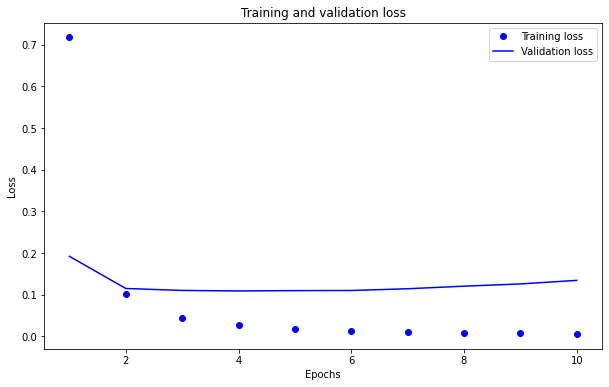

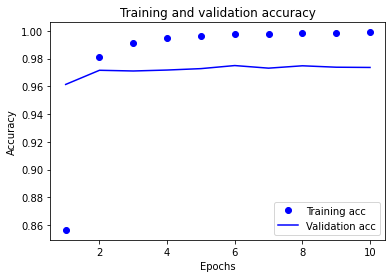

In [0]:
model_4 = models.Sequential()
model_4.add(layers.Embedding(10000, 128))
# model_1.add(layers.LSTM(128,dropout=0.2,recurrent_dropout=0.2,return_sequences=True))
model_4.add(layers.LSTM(16,dropout=0.15,recurrent_dropout=0.15))
model_4.add(layers.Dense(5, activation='softmax'))

model_4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Iterate on your training data by calling the fit() method of your model
history = model_4.fit(X_par_train_res, y_par_train_res,
                    epochs=10,
                    batch_size=500,
                    validation_data = (X_val,y_val)
                    #class_weight = class_weights
                    )

# plot the results of loss values from the training set and validtion set
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# plot the results of accuracy from the training set and validtion set
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Performance on partial training set

In [0]:
preds_Y_par_train = model_4.predict(X_par_train)
preds_Y_par_train =(preds_Y_par_train>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_par_train_copy = enc.inverse_transform(preds_Y_par_train)
y_par_train_copy = enc.inverse_transform(y_par_train)

# Change all categorical data to numbers, so we can compute accuracy, precision, confusion matrix,....
le = sklearn.preprocessing.LabelEncoder()
y_par_train_copy = le.fit_transform(y_par_train_copy)
preds_Y_par_train_copy = le.transform(preds_Y_par_train_copy)

accuracy = accuracy_score(y_par_train_copy, preds_Y_par_train_copy)
precision = precision_score(y_par_train_copy, preds_Y_par_train_copy,average=None) # average=None: The precision scores for each class are returned
recall = recall_score(y_par_train_copy, preds_Y_par_train_copy,average=None)
f1 = f1_score(y_par_train_copy, preds_Y_par_train_copy,average=None)
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')

c_matrix = confusion_matrix(y_par_train_copy, preds_Y_par＿train_copy,labels=[0,1,2,3,4])
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.9984679547195506

precision: [0.95701357 0.99976706 0.99948789 0.99810407 1.        ]

recall: [1.         0.9988364  0.99853823 0.99768372 1.        ]

F1 score: [0.97803468 0.99930151 0.99901283 0.99789385 1.        ]

Confusion matrix: 
[[  423     0     0     0     0]
 [    3  4292     1     1     0]
 [   11     1 13662     8     0]
 [    5     0     6  4738     0]
 [    0     0     0     0   347]]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
le.classes_

array(['A_會計/財報分析', 'F_市場交易', 'I_產業前景', 'M_經營層', 'R_危機'], dtype=object)

## Performance on testing set

In [0]:
preds_Y_test = model_4.predict(X_test)
preds_Y_test =(preds_Y_test>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_test_copy = enc.inverse_transform(preds_Y_test)
y_test_copy = enc.inverse_transform(y_test)

# Change all categorical data to numbers, so we can compute accuracy, precision, confusion matrix,....
le = sklearn.preprocessing.LabelEncoder()
y_test_copy = le.fit_transform(y_test_copy)
preds_Y_test_copy = le.transform(preds_Y_test_copy)

accuracy = accuracy_score(y_test_copy, preds_Y_test_copy)
precision = precision_score(y_test_copy, preds_Y_test_copy,average=None) # average=None: The precision scores for each class are returned
recall = recall_score(y_test_copy, preds_Y_test_copy,average=None)
f1 = f1_score(y_test_copy, preds_Y_test_copy,average=None)
c_matrix = confusion_matrix(y_test_copy, preds_Y_test_copy,labels=[0,1,2,3,4])
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.9719498910675382

precision: [0.73109244 0.99407407 0.97362894 0.97121821 0.89583333]

recall: [0.75       0.97458243 0.98698841 0.95147541 0.86868687]

F1 score: [0.74042553 0.98423176 0.98026316 0.96124545 0.88205128]

Confusion matrix: 
[[  87    0   28    1    0]
 [   2 1342   17    8    8]
 [  17    3 4172   34    1]
 [  10    1   62 1451    1]
 [   3    4    6    0   86]]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
le.classes_

array(['A_會計/財報分析', 'F_市場交易', 'I_產業前景', 'M_經營層', 'R_危機'], dtype=object)

# Model 5:

Reduce the units of LSTM to 16

Use Random Oversampling

sequence length = 1305 (max length of our text data)

Drop: 0.2, recurrent dropout:0.2

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 68410 samples, validate on 5875 samples
Epoch 1/10
68410/68410 [==============================] - 348s 5ms/step - loss: 0.7345 - accuracy: 0.8925 - val_loss: 0.2006 - val_accuracy: 0.9569
Epoch 2/10
68410/68410 [==============================] - 352s 5ms/step - loss: 0.1051 - accuracy: 0.9793 - val_loss: 0.1195 - val_accuracy: 0.9695
Epoch 3/10
68410/68410 [==============================] - 350s 5ms/step - loss: 0.0474 - accuracy: 0.9904 - val_loss: 0.1096 - val_accuracy: 0.9726
Epoch 4/10
68410/68410 [==============================] - 351s 5ms/step - loss: 0.0304 - accuracy: 0.9940 - val_loss: 0.1065 - val_accuracy: 0.9731
Epoch 5/10
68410/68410 [==============================] - 348s 5ms/step - loss: 0.0216 - accuracy: 0.9955 - val_loss: 0.1088 - val_accuracy: 0.9736
Epoch 6/10
68410/68410 [==============================] - 350s 5ms/step - loss: 0.0158 - accuracy: 0.9969 - val_loss: 0.1097 - val_accuracy: 0.9731
Epoch 7/10
68410/68410 [==============================] - 347s 

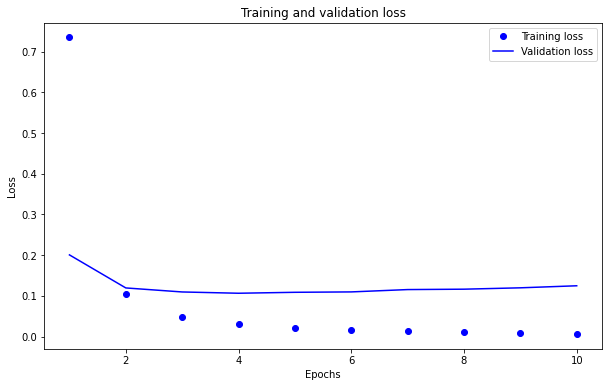

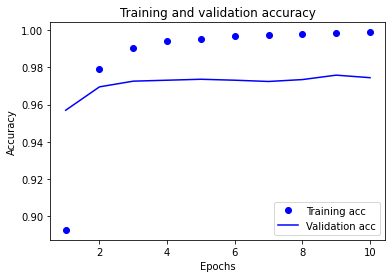

In [0]:
model_5 = models.Sequential()
model_5.add(layers.Embedding(10000, 128))
model_5.add(layers.LSTM(16,dropout=0.2,recurrent_dropout=0.2))
model_5.add(layers.Dense(5, activation='softmax'))

model_5.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Iterate on your training data by calling the fit() method of your model
history = model_5.fit(X_par_train_res, y_par_train_res,
                    epochs=10,
                    batch_size=500,
                    validation_data = (X_val,y_val)
                    #class_weight = class_weights
                    )

# plot the results of loss values from the training set and validtion set
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# plot the results of accuracy from the training set and validtion set
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Performance on partial training set

In [0]:
preds_Y_par_train = model_5.predict(X_par_train)
preds_Y_par_train =(preds_Y_par_train>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_par_train_copy = enc.inverse_transform(preds_Y_par_train)
y_par_train_copy = enc.inverse_transform(y_par_train)

# Change all categorical data to numbers, so we can compute accuracy, precision, confusion matrix,....
le = sklearn.preprocessing.LabelEncoder()
y_par_train_copy = le.fit_transform(y_par_train_copy)
preds_Y_par_train_copy = le.transform(preds_Y_par_train_copy)

accuracy = accuracy_score(y_par_train_copy, preds_Y_par_train_copy)
precision = precision_score(y_par_train_copy, preds_Y_par_train_copy,average=None) # average=None: The precision scores for each class are returned
recall = recall_score(y_par_train_copy, preds_Y_par_train_copy,average=None)
f1 = f1_score(y_par_train_copy, preds_Y_par_train_copy,average=None)
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')

c_matrix = confusion_matrix(y_par_train_copy, preds_Y_par＿train_copy,labels=[0,1,2,3,4])
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.998382841092859

precision: [0.95918367 0.99906868 0.99970709 0.99747846 1.        ]

recall: [1.         0.99860368 0.99780734 0.99957886 1.        ]

F1 score: [0.97916667 0.99883613 0.99875631 0.99852756 1.        ]

Confusion matrix: 
[[  423     0     0     0     0]
 [    4  4291     2     0     0]
 [   14     4 13652    12     0]
 [    0     0     2  4747     0]
 [    0     0     0     0   347]]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
le.classes_

array(['A_會計/財報分析', 'F_市場交易', 'I_產業前景', 'M_經營層', 'R_危機'], dtype=object)

## Performance on testing set

In [0]:
preds_Y_test = model_5.predict(X_test)
preds_Y_test =(preds_Y_test>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_test_copy = enc.inverse_transform(preds_Y_test)
y_test_copy = enc.inverse_transform(y_test)

# Change all categorical data to numbers, so we can compute accuracy, precision, confusion matrix,....
le = sklearn.preprocessing.LabelEncoder()
y_test_copy = le.fit_transform(y_test_copy)
preds_Y_test_copy = le.transform(preds_Y_test_copy)

accuracy = accuracy_score(y_test_copy, preds_Y_test_copy)
precision = precision_score(y_test_copy, preds_Y_test_copy,average=None) # average=None: The precision scores for each class are returned
recall = recall_score(y_test_copy, preds_Y_test_copy,average=None)
f1 = f1_score(y_test_copy, preds_Y_test_copy,average=None)
c_matrix = confusion_matrix(y_test_copy, preds_Y_test_copy,labels=[0,1,2,3,4])
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.9709967320261438

precision: [0.671875   0.99480712 0.97855796 0.9593709  0.8877551 ]

recall: [0.74137931 0.97385621 0.98249349 0.96       0.87878788]

F1 score: [0.70491803 0.98422018 0.98052178 0.95968535 0.88324873]

Confusion matrix: 
[[  86    0   28    2    0]
 [   3 1341   13   11    9]
 [  23    2 4153   49    0]
 [  13    1   45 1464    2]
 [   3    4    5    0   87]]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
le.classes_

array(['A_會計/財報分析', 'F_市場交易', 'I_產業前景', 'M_經營層', 'R_危機'], dtype=object)

# Model 6:

ADJUST CLASS WEIGHTS

sequence length = 1305 (max length of our text data)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 23498 samples, validate on 5875 samples
Epoch 1/10
23498/23498 [==============================] - 166s 7ms/step - loss: 0.8735 - accuracy: 0.8245 - val_loss: 0.2742 - val_accuracy: 0.9418
Epoch 2/10
23498/23498 [==============================] - 161s 7ms/step - loss: 0.1808 - accuracy: 0.9448 - val_loss: 0.1350 - val_accuracy: 0.9546
Epoch 3/10
23498/23498 [==============================] - 161s 7ms/step - loss: 0.0884 - accuracy: 0.9735 - val_loss: 0.1044 - val_accuracy: 0.9695
Epoch 4/10
23498/23498 [==============================] - 161s 7ms/step - loss: 0.0481 - accuracy: 0.9869 - val_loss: 0.1068 - val_accuracy: 0.9704
Epoch 5/10
23498/23498 [==============================] - 162s 7ms/step - loss: 0.0288 - accuracy: 0.9921 - val_loss: 0.1093 - val_accuracy: 0.9724
Epoch 6/10
23498/23498 [==============================] - 163s 7ms/step - loss: 0.0212 - accuracy: 0.9942 - val_loss: 0.1478 - val_accuracy: 0.9641
Epoch 7/10
23498/23498 [==============================] - 163s 

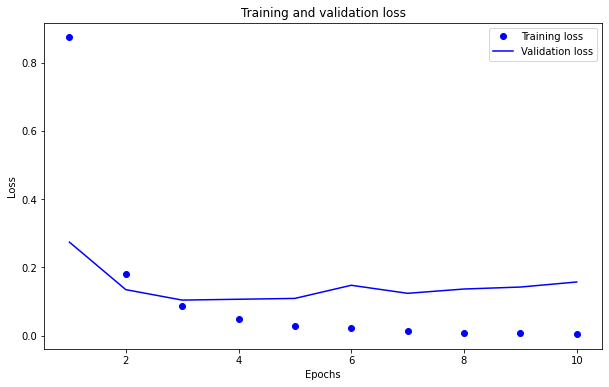

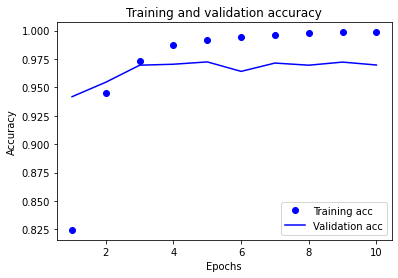

In [10]:
model_6 = models.Sequential()
model_6.add(layers.Embedding(10000, 128))
model_6.add(layers.LSTM(64,dropout=0,recurrent_dropout=0))
model_6.add(layers.Dense(32, activation='relu'))
model_6.add(layers.Dense(32, activation='relu'))
model_6.add(layers.Dense(5, activation='softmax'))

model_6.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Iterate on your training data by calling the fit() method of your model
history = model_6.fit(X_par_train, y_par_train,
                    epochs=10,
                    batch_size=500,
                    validation_data = (X_val,y_val),
                    class_weight = class_weights
                    )

# plot the results of loss values from the training set and validtion set
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# plot the results of accuracy from the training set and validtion set
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Performance on partial training set

In [11]:
preds_Y_par_train = model_6.predict(X_par_train)
preds_Y_par_train =(preds_Y_par_train>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_par_train_copy = enc.inverse_transform(preds_Y_par_train)
y_par_train_copy = enc.inverse_transform(y_par_train)

# Change all categorical data to numbers, so we can compute accuracy, precision, confusion matrix,....
le = sklearn.preprocessing.LabelEncoder()
y_par_train_copy = le.fit_transform(y_par_train_copy)
preds_Y_par_train_copy = le.transform(preds_Y_par_train_copy)

accuracy = accuracy_score(y_par_train_copy, preds_Y_par_train_copy)
precision = precision_score(y_par_train_copy, preds_Y_par_train_copy,average=None) # average=None: The precision scores for each class are returned
recall = recall_score(y_par_train_copy, preds_Y_par_train_copy,average=None)
f1 = f1_score(y_par_train_copy, preds_Y_par_train_copy,average=None)
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')

c_matrix = confusion_matrix(y_par_train_copy, preds_Y_par＿train_copy,labels=[0,1,2,3,4])
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.9981275002127841

precision: [0.97018349 0.99976723 0.99985346 0.99413367 1.        ]

recall: [1.         0.99953456 0.99736881 0.99915772 0.99423631]

F1 score: [0.98486612 0.99965088 0.99860959 0.99663936 0.99710983]

Confusion matrix: 
[[  423     0     0     0     0]
 [    1  4295     0     1     0]
 [    9     0 13646    27     0]
 [    2     0     2  4745     0]
 [    1     1     0     0   345]]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
le.classes_

array(['A_會計/財報分析', 'F_市場交易', 'I_產業前景', 'M_經營層', 'R_危機'], dtype=object)

## Performance on testing set

In [13]:
preds_Y_test = model_6.predict(X_test)
preds_Y_test =(preds_Y_test>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_test_copy = enc.inverse_transform(preds_Y_test)
y_test_copy = enc.inverse_transform(y_test)

# Change all categorical data to numbers, so we can compute accuracy, precision, confusion matrix,....
le = sklearn.preprocessing.LabelEncoder()
y_test_copy = le.fit_transform(y_test_copy)
preds_Y_test_copy = le.transform(preds_Y_test_copy)

accuracy = accuracy_score(y_test_copy, preds_Y_test_copy)
precision = precision_score(y_test_copy, preds_Y_test_copy,average=None) # average=None: The precision scores for each class are returned
recall = recall_score(y_test_copy, preds_Y_test_copy,average=None)
f1 = f1_score(y_test_copy, preds_Y_test_copy,average=None)
c_matrix = confusion_matrix(y_test_copy, preds_Y_test_copy,labels=[0,1,2,3,4])
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.9666394335511983

precision: [0.75       0.99410464 0.97877921 0.92655367 0.96590909]

recall: [0.72413793 0.97966594 0.97113792 0.96786885 0.85858586]

F1 score: [0.73684211 0.98683248 0.97494359 0.94676074 0.90909091]

Confusion matrix: 
[[  84    0   30    2    0]
 [   2 1349   11   13    2]
 [  20    2 4105  100    0]
 [   3    1   44 1476    1]
 [   3    5    4    2   85]]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
le.classes_

array(['A_會計/財報分析', 'F_市場交易', 'I_產業前景', 'M_經營層', 'R_危機'], dtype=object)

# Model 7:

ADJUST CLASS WEIGHTS

Use "Dropout" for dense layers

sequence length = 1305 (max length of our text data)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 23498 samples, validate on 5875 samples
Epoch 1/10
23498/23498 [==============================] - 166s 7ms/step - loss: 0.9891 - accuracy: 0.6889 - val_loss: 0.4418 - val_accuracy: 0.9372
Epoch 2/10
23498/23498 [==============================] - 166s 7ms/step - loss: 0.2417 - accuracy: 0.9364 - val_loss: 0.1537 - val_accuracy: 0.9467
Epoch 3/10
23498/23498 [==============================] - 165s 7ms/step - loss: 0.1238 - accuracy: 0.9551 - val_loss: 0.1372 - val_accuracy: 0.9525
Epoch 4/10
23498/23498 [==============================] - 165s 7ms/step - loss: 0.0847 - accuracy: 0.9682 - val_loss: 0.1402 - val_accuracy: 0.9648
Epoch 5/10
23498/23498 [==============================] - 162s 7ms/step - loss: 0.0519 - accuracy: 0.9827 - val_loss: 0.1427 - val_accuracy: 0.9670
Epoch 6/10
23498/23498 [==============================] - 161s 7ms/step - loss: 0.0358 - accuracy: 0.9896 - val_loss: 0.1418 - val_accuracy: 0.9745
Epoch 7/10
23498/23498 [==============================] - 162s 

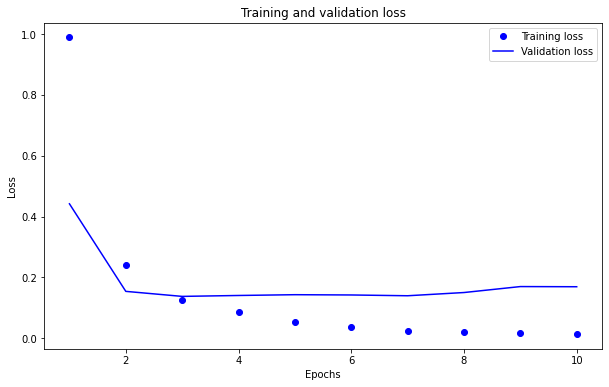

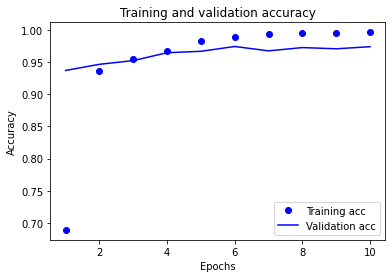

In [15]:
model_7 = models.Sequential()
model_7.add(layers.Embedding(10000, 128))
model_7.add(layers.LSTM(64,dropout=0,recurrent_dropout=0))
model_7.add(layers.Dense(32, activation='relu'))
model_7.add(layers.Dropout(0.1))
model_7.add(layers.Dense(32, activation='relu'))
model_7.add(layers.Dropout(0.2))
model_7.add(layers.Dense(5, activation='softmax'))

model_7.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Iterate on your training data by calling the fit() method of your model
history = model_7.fit(X_par_train, y_par_train,
                    epochs=10,
                    batch_size=500,
                    validation_data = (X_val,y_val),
                    class_weight = class_weights
                    )

# plot the results of loss values from the training set and validtion set
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# plot the results of accuracy from the training set and validtion set
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Performance on partial training set

In [16]:
preds_Y_par_train = model_7.predict(X_par_train)
preds_Y_par_train =(preds_Y_par_train>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_par_train_copy = enc.inverse_transform(preds_Y_par_train)
y_par_train_copy = enc.inverse_transform(y_par_train)

# Change all categorical data to numbers, so we can compute accuracy, precision, confusion matrix,....
le = sklearn.preprocessing.LabelEncoder()
y_par_train_copy = le.fit_transform(y_par_train_copy)
preds_Y_par_train_copy = le.transform(preds_Y_par_train_copy)

accuracy = accuracy_score(y_par_train_copy, preds_Y_par_train_copy)
precision = precision_score(y_par_train_copy, preds_Y_par_train_copy,average=None,labels=[0,1,2,3,4]) # average=None: The precision scores for each class are returned
recall = recall_score(y_par_train_copy, preds_Y_par_train_copy,average=None,labels=[0,1,2,3,4])
f1 = f1_score(y_par_train_copy, preds_Y_par_train_copy,average=None,labels=[0,1,2,3,4])
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')

c_matrix = confusion_matrix(y_par_train_copy, preds_Y_par＿train_copy,labels=[0,1,2,3,4])
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.9986381819729339

precision: [0.96136364 0.99860368 0.99956131 0.99957833 0.99706745]

recall: [1.         0.99860368 0.99919602 0.99831543 0.97982709]

F1 score: [0.98030127 0.99860368 0.99937863 0.99894648 0.98837209]

Confusion matrix: 
[[  423     0     0     0     0]
 [    3  4291     2     0     1]
 [    8     1 13671     2     0]
 [    4     0     4  4741     0]
 [    2     5     0     0   340]]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:
le.classes_

array(['A_會計/財報分析', 'F_市場交易', 'I_產業前景', 'M_經營層', 'R_危機'], dtype=object)

## Performance on testing set

In [18]:
preds_Y_test = model_7.predict(X_test)
preds_Y_test =(preds_Y_test>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_test_copy = enc.inverse_transform(preds_Y_test)
y_test_copy = enc.inverse_transform(y_test)

# Change all categorical data to numbers, so we can compute accuracy, precision, confusion matrix,....
le = sklearn.preprocessing.LabelEncoder()
y_test_copy = le.fit_transform(y_test_copy)
preds_Y_test_copy = le.transform(preds_Y_test_copy)

accuracy = accuracy_score(y_test_copy, preds_Y_test_copy)
precision = precision_score(y_test_copy, preds_Y_test_copy,average=None,labels=[0,1,2,3,4]) # average=None: The precision scores for each class are returned
recall = recall_score(y_test_copy, preds_Y_test_copy,average=None,labels=[0,1,2,3,4])
f1 = f1_score(y_test_copy, preds_Y_test_copy,average=None,labels=[0,1,2,3,4])
c_matrix = confusion_matrix(y_test_copy, preds_Y_test_copy,labels=[0,1,2,3,4])
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.968681917211329

precision: [0.63432836 0.98396501 0.97716035 0.96217651 0.94047619]

recall: [0.73275862 0.98039216 0.98178377 0.95081967 0.7979798 ]

F1 score: [0.68       0.98217534 0.9794666  0.95646438 0.86338798]

Confusion matrix: 
[[  85    1   26    2    2]
 [   1 1350   16    8    2]
 [  26    4 4150   46    1]
 [  19    4   52 1450    0]
 [   3   13    3    1   79]]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [19]:
le.classes_

array(['A_會計/財報分析', 'F_市場交易', 'I_產業前景', 'M_經營層', 'R_危機'], dtype=object)

# Use all data to train our final Big_Event_Classifier

## Choose Model 5


In [0]:
X = preprocess_text(corpus = data_df.content_tokenized, MAX_NUM_WORDS = 10000, MAX_SEQUENCE_LENGTH = 1305)

y = data_df["大事件類別"]

# Calculate class weights

print(np.unique(y))

class_weights = class_weight.compute_class_weight('balanced',np.unique(y),y)

print(class_weights)

# One-hot encoding
enc = OneHotEncoder(sparse=False)
y = enc.fit_transform(np.asarray(y).reshape(-1, 1))

# Oversampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X, y = ros.fit_resample(X, y)

['A_會計/財報分析' 'F_市場交易' 'I_產業前景' 'M_經營層' 'R_危機']
[11.58264984  1.09179304  0.34408209  0.98186923 13.70037313]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
model = models.Sequential()
model.add(layers.Embedding(10000, 128))
model.add(layers.LSTM(16,dropout=0.2,recurrent_dropout=0.2))
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Iterate on your training data by calling the fit() method of your model
model.fit(X, y,epochs=10,batch_size=500)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
106710/106710 [==============================] - 816s 8ms/step - loss: 0.5555 - accuracy: 0.8806
Epoch 2/10
106710/106710 [==============================] - 810s 8ms/step - loss: 0.0941 - accuracy: 0.9787
Epoch 3/10
106710/106710 [==============================] - 807s 8ms/step - loss: 0.0505 - accuracy: 0.9881
Epoch 4/10
106710/106710 [==============================] - 810s 8ms/step - loss: 0.0320 - accuracy: 0.9924
Epoch 5/10
106710/106710 [==============================] - 812s 8ms/step - loss: 0.0231 - accuracy: 0.9948
Epoch 6/10
106710/106710 [==============================] - 809s 8ms/step - loss: 0.0178 - accuracy: 0.9958
Epoch 7/10
106710/106710 [==============================] - 812s 8ms/step - loss: 0.0143 - accuracy: 0.9968
Epoch 8/10
106710/106710 [==============================] - 810s 8ms/step - loss: 0.0124 - accuracy: 0.9971
Epoch 9/10
106710/106710 [==============================] - 809s 8ms/step - loss: 0.0105 - accuracy: 0.9975
Epoch 10/10
106710/106710 [=

# Save Big_Event_Classifier

In [0]:
# SAVE MODEL
model.save('gdrive/My Drive/金融科技Final_project/Big_Event_Classifier')